# Settings

## Imports

In [ ]:
!pip install tensorflow
!pip install matplotlib
!pip install opencv-python
!pip install numpy
!pip install pandas
!pip install beautifulsoup4
!pip install --ignore-installed Pillow==9.0.0

In [ ]:
#Tensorflow related imports
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom,RandomBrightness,Rescaling

from tensorflow.keras import Input, Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import datetime
import pandas as pd
import time
import random
import shutil
import sys
from enum import Enum, auto
from bs4 import BeautifulSoup
from numpy import asarray, arange, mgrid, ndarray
from PIL import Image, ImageDraw
#import lxml

## Support Functions

## Settings

In [ ]:
#Location for training, validation, testing
training_img_dir = "/content/drive/MyDrive/tf_workspace/Images/Classification_Images/trainFD"
validation_img_dir = "/content/drive/MyDrive/tf_workspace/Images/Classification_Images/testFD"
#testing_img_dir = "/content/drive/MyDrive/tf_workspace/training_cnn/images/testing"



#Model Training Settings
modelName="CNN_V1"
modelFolderName = "CNN/Classfication/"+modelName  #Location where the trained model should be stored (last part is the name of the folder)
batch_size = 32#64                             #Amount of images per batch
training_epochs=50                          #Training epochs
STEPS_BETWEEN_SAVES = 10
EARLY_STOP = True                          #Setting that allows the model to stop training earlier if it goes into overfitting.
CONTINUOUS_SAVE= True
targetSizeElement = 256                      #Image Size could be integer or tuple (if integer then ne number is for x and y)
maxImages = 1
#target_shape, input_shape = getCnnShapes(targetSizeElement)

# Initialize CNN Training

## Initialize Helper Functions

In [ ]:
def parse_record(record):
    # Define the feature map for the desired features
    feature_map = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        # Add more features that you want to extract
    }
    
    # Parse a single example from the TFRecord dataset using the feature map
    example = tf.io.parse_single_example(record, feature_map)

    # Convert sparse features to dense tensors
    image = example['image/encoded']
    xmin = tf.sparse.to_dense(example['image/object/bbox/xmin']).numpy().tolist()
    ymin = tf.sparse.to_dense(example['image/object/bbox/ymin']).numpy().tolist()
    xmax = tf.sparse.to_dense(example['image/object/bbox/xmax']).numpy().tolist()
    ymax = tf.sparse.to_dense(example['image/object/bbox/ymax']).numpy().tolist()
    label = tf.sparse.to_dense(example['image/object/class/label']).numpy().tolist()
    
    # Create the dictionary with the extracted features
    data = {
        'enc_img': image,
        'xmin': xmin,
        'ymin': ymin,
        'xmax': xmax,
        'ymax': ymax,
        'label': label,
        # Add more keys for other features
    }
    
    return data

def read_records(file_path):
    # Read the TFRecord dataset from the specified file
    dataset = tf.data.TFRecordDataset(file_path)
    
    # Apply the parse_record function to each record and store the result in a list
    parsed_records = [parse_record(record) for record in dataset]
    
    return parsed_records


In [ ]:
def calculate_center(xMin, yMin, xMax, yMax):
    # Calculate the center coordinates of a bounding box
    xCenter = (xMin + xMax) / 2
    yCenter = (yMin + yMax) / 2
    return xCenter, yCenter

def get_cell_section(centerPoint, amtCells):
    # Determine the section of a grid cell that a point falls into
    return int(round(centerPoint / (1 / amtCells), 0))

def getClassListSection(label, maxClasses):
    # Create a one-hot encoded array for the class label
    classList = np.zeros(maxClasses)
    classList[label-1] = 1
    return classList

def orderList(data, tableCellAmount):
    # Create an ordered list based on the provided data and the number of cells in a table
    shape = (tableCellAmount, tableCellAmount, 8)
    tableSection = np.zeros(shape)
    xMin = data["xmin"]
    yMin = data["ymin"]
    xMax = data["xmax"]
    yMax = data["ymax"]
    label = data["label"]

    for index, _ in enumerate(xMin):
        # Calculate the center coordinates of the bounding box
        xCenter, yCenter = calculate_center(xMin[index], yMin[index], xMax[index], yMax[index])
        
        # Determine the grid cell section for the center coordinates
        xSection, ySection = get_cell_section(xCenter, tableCellAmount), get_cell_section(yCenter, tableCellAmount)
        
        # Create an array representing the object's location and class
        objLoc = np.array([xMin[index], yMin[index], xMax[index], yMax[index]])
        objClass = getClassListSection(label[index], 4)
        objList = np.concatenate([objLoc, objClass])
        
        # Assign the object's list to the corresponding table section
        tableSection[xSection][ySection] = objList
    
    return tableSection


In [ ]:
def getDataSet(file_path):
    tableCellAmount = 9
    
    # Read and parse the records from the file
    parsed_data = read_records(file_path)
    
    # Create an empty array for the ordered table sections
    shape = (len(parsed_data), tableCellAmount, tableCellAmount, 8)
    trueTable = np.zeros(shape)
    
    # Create a list for the image data
    imgTable = []
    
    # Iterate over the parsed data
    for index, element in enumerate(parsed_data):
        # Order the data and store the result in the trueTable array
        result = orderList(element, tableCellAmount)
        trueTable[index] = result
        
        # Retrieve the image data and store it in the imgTable list
        image = element["enc_img"]
        imgTable.append(image)
    
    # Convert the imgTable list to a TensorFlow tensor
    imgTable = tf.stack(imgTable)
    
    # Create a TensorFlow dataset from the image and true table data
    dataset = tf.data.Dataset.from_tensor_slices((imgTable, trueTable))
    
    # Print information about the dataset
    print(f"The dataset contains {len(imgTable)} images and {len(trueTable)} labels")
    
    return dataset


## Load Datasets

In [ ]:
#Load the data for training
train_dataset = getDataSet("/content/drive/MyDrive/tf_workspace/Images/Classification_Images/annotations/train.record")
train_dataset2 = train_dataset.batch(batch_size)

Conversion done, gernerate datset
Table Converted
The dataset contains of 3874 images and 3874 label


In [ ]:
#Load  the data for validation
val_dataset = getDataSet("/content/drive/MyDrive/tf_workspace/Images/Classification_Images/annotations/test.record")
val_dataset2 = val_dataset.batch(batch_size)

Conversion done, gernerate datset
Table Converted
The dataset contains of 965 images and 965 label


# Training the model


In [ ]:
def create_custom_model(target_size):
    # Define the input shape
    inputs = Input(shape=(target_size, target_size, 3), dtype=tf.float32)

    # Data augmentation layers
    imgAdjust = RandomFlip("horizontal_and_vertical")(inputs)
    imgAdjust = RandomRotation(0.5)(imgAdjust)
    imgAdjust = RandomZoom(0.5, 0.2)(imgAdjust)
    imgAdjust = RandomBrightness(0.5)(imgAdjust)
    imgAdjust = Rescaling(1./255)(imgAdjust)

    # Convolutional layers
    x = Conv2D(32, kernel_size=7, activation="relu", padding="same", input_shape=(target_size, target_size, 3))(imgAdjust)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(32, kernel_size=7, activation="relu", padding="same")(x)
    x = MaxPooling2D(pool_size=2)(x)

    # Additional convolutional layers
    x_more = Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
    x_more = MaxPooling2D(pool_size=2)(x_more)
    x_more = Conv2D(128, kernel_size=3, activation="relu", padding="same")(x_more)
    x_more = MaxPooling2D(pool_size=2)(x_more)
    x_more = Conv2D(256, kernel_size=3, activation="relu", padding="same")(x_more)
    x_more = MaxPooling2D(pool_size=2)(x_more)

    # Flatten and fully connected layers
    x_more = Flatten()(x_more)
    x_more = Dense(1440)(x_more)
    x_more = Dropout(0.5)(x_more)
    x_more = Dense(648)(x_more)

    # Create the model
    model = CustomModel(inputs, x_more)
    return model


In [ ]:
def decode_and_resize_image(image):
    # Decode the JPEG image
    decoded_image = tf.image.decode_jpeg(image)
    # Convert the image to float32 data type
    decoded_image = tf.cast(decoded_image, dtype=tf.float32)
    # Resize the image to the target size using nearest neighbor interpolation
    resized_image = tf.image.resize(decoded_image, (targetSizeElement, targetSizeElement), method='nearest')
    # Normalize the pixel values to the range [0, 1]
    resized_image = resized_image / 255.0
    return resized_image


Use Custom Model Class to be able to decode images during training

In [ ]:
class CustomModel(keras.Model):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        #self.val_loss_tracker = keras.metrics.Mean(name="val_loss")

    def custom_loss(self,y, y_pred):
      pred_coords = y_pred[..., :4]
      pred_classes = y_pred[..., 4:]

      true_coords = y[..., :4]
      true_classes = y[..., 4:]
      # Compute the localization loss
      coord_loss = tf.reduce_sum(tf.square(pred_coords - true_coords), axis=-1)

      # Compute the classification loss
      class_loss = tf.reduce_sum(tf.square(pred_classes - true_classes), axis=-1)

      # Compute the total loss
      loss = tf.reduce_mean(coord_loss + class_loss)

      return loss

    def train_step(self, data):

        x, y = data
        x = tf.map_fn(decode_and_resize_image, x, dtype=tf.float32)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            y = tf.cast(y, dtype=tf.float32)
            y_pred = tf.reshape(y_pred, (-1, 9, 9, 8))
            loss = self.custom_loss(y=y, y_pred=y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

Load and train the model

In [ ]:
model = create_custom_model(targetSizeElement)
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

model.fit(train_dataset2, epochs=50, verbose=1)

Epoch 1/50
122/122 [==============================] - 25s 206ms/step - mse: 0.0032 - loss: 0.0258
Epoch 2/50
122/122 [==============================] - 25s 202ms/step - mse: 0.0032 - loss: 0.0255
Epoch 3/50
122/122 [==============================] - 25s 203ms/step - mse: 0.0032 - loss: 0.0255
Epoch 4/50
122/122 [==============================] - 25s 202ms/step - mse: 0.0032 - loss: 0.0255
Epoch 5/50
122/122 [==============================] - 25s 202ms/step - mse: 0.0032 - loss: 0.0254
Epoch 6/50
122/122 [==============================] - 25s 203ms/step - mse: 0.0032 - loss: 0.0254
Epoch 7/50
122/122 [==============================] - 26s 210ms/step - mse: 0.0032 - loss: 0.0254
Epoch 8/50
122/122 [==============================] - 25s 202ms/step - mse: 0.0032 - loss: 0.0254
Epoch 9/50
122/122 [==============================] - 25s 202ms/step - mse: 0.0032 - loss: 0.0254
Epoch 10/50
122/122 [==============================] - 25s 203ms/step - mse: 0.0032 - loss: 0.0254
Epoch 11/50
122/122

# Test the model

In [ ]:
#Grab a random image from validation dataset
val_dataset_shuffled = val_dataset.shuffle(buffer_size=1000)  # Example buffer size
random_val_element = val_dataset_shuffled.take(1)


# Convert the image to a batch dimension
image_decoded = tf.image.decode_jpeg(random_val_element)
resized_image = tf.image.resize(image_decoded, [targetSizeElement, targetSizeElement], method='nearest')
image_decoded_with_none_dim = tf.expand_dims(resized_image, axis=0)

# Make predictions with the model on the image
result = model.predict(image_decoded_with_none_dim)

(9, 9, 8)
-0.0010962365 -0.000315756 0.0031922818 0.0031137588


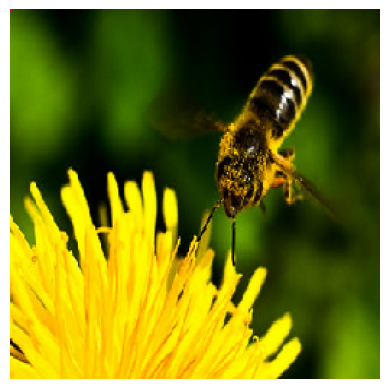

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Example NumPy array with shape (9, 9, 8)
array = reshaped_array[0]
print(array.shape)

# Loop over the array
for i in range(array.shape[0]):
    for j in range(array.shape[1]):
        subarray = array[i, j, :]
        diff_1 = subarray[3] - subarray[1]
        diff_2 = subarray[4] - subarray[2]
        if diff_1 > 0.002 and diff_2 > 0.002:
            # Draw the rectangle
            image_height, image_width, _ = resized_image.shape
            xmin = subarray[1] * image_width
            ymin = subarray[2] * image_height
            width = diff_1 * image_width
            height = diff_2 * image_height

            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            print(subarray[1], subarray[2], diff_1, diff_2)

            # Show the image
            plt.imshow(resized_image)
            plt.axis('off')

            # Add the rectangle to the image
            plt.gca().add_patch(rect)

            plt.show()
            break
    else:
        continue
    break


# Model Informations

In [ ]:
model.summary()

In [ ]:
imageLocation = "/content/drive/MyDrive/tf_workspace/"+modelFolderName+f"/{modelName}.jpg"
plot_model(model, show_shapes=True, to_file=imageLocation)